# Clasificación de dígitos MNIST mediante AdaBoost

##**Introducción**

En esta práctica vamos a abordar el problema de reconocimiento de dígitos en imágenes, concretamente las imágenes del conjunto de MNIST. Para ello, vamos a implementar el algoritmo de Adaboost, con el cual, obtendremos un clasificador fuerte que nos determinará el dígito que aparece en dicha imagen. 

A continuación, explicaremos cuestiones teóricas de dicho algoritmo, como se implementa y algunos de sus requisitos.

### Requisitos
Lo primero que debemos hacer es importar las librerías necesarias, estas son:


*   NumPy: Tratamiento de números, vectores numéricos y ciertas operaciones sobre estos.
*   Math: Para realizar ciertas operaciones matemáticas y el número e.
*   Random: Para generar números aleatorios.
*   MatplotLib: Para generar gráficas sobre los procesos realizados.
*   mnist: Para importar el conjunto de dígitos sobre el cual trabajaremos.



In [ ]:
import numpy as np
import random, math, time
from math import e
import matplotlib.pyplot as plt
from keras.datasets import mnist
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

###Conjunto de entrenamiento y conjunto de test
Desde la libería de Keras podemos descargar la base datos MNIST, de la cual nos descargaremos 4 conjuntos de datos, 2 usaremos para el entrenamiento de nuestros clasificadores y los otros 2 para la evaluación de los mismos. Dichos conjuntos tienen una talla considerablemente grande, concretamente 60.000 imágenes el conjunto de entrenamiento y 10.000 el conjunto de evaluación.

En la mayoría de pruebas usaremos la completitud de los conjuntos, pero en determinados análisis (por ejemplo, análisis conjunto de T y A) reduciremos el tamaño debido a la complejidad computacional de estos.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


Como podemos observar, vamos a mostrar el tamaño y dimensión de los conjuntos descargados de MNIST:

In [ ]:
print("Las conjuntos de datos a usar son:\n\nPara entrenamiento\n------------------------\nx_train: {}\ny_train: {}\n\nPara test\n------------------------\nx_test: {}\ny_test:{}".format(x_train.shape,y_train.shape, x_test.shape, y_test.shape))

Las conjuntos de datos a usar son:

Para entrenamiento
------------------------
x_train: (60000, 28, 28)
y_train: (60000,)

Para test
------------------------
x_test: (10000, 28, 28)
y_test:(10000,)


A continuación podemos apreciar que la base de datos MNIST contiene digitos manuscritos en el vector de las X(x_train y x_test en nuestro caso) y su correspondiente etiqueta la almacena en el vector de Y (y_train y y_test), dos ejemplos son los que aparecen a continuación:

Etiqueta: 0


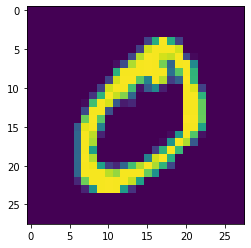



Etiqueta: 9


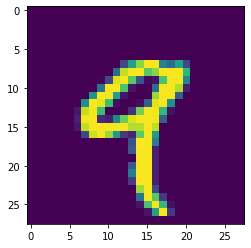

In [ ]:
print("Etiqueta: " + str(y_train[1]))
plt.figure()
plt.imshow(x_train[1])
plt.show()



print("\n\nEtiqueta: " + str(y_train[4]))
plt.figure()
plt.imshow(x_train[4])
plt.show()


##**¿Que es adaboost?**

Adaboost es un algoritmo de aprendizaje automático el cual se basa en el termino de boosting. Esto quiere decir que es un tipo de algoritmo que se basa en encontrar una hipótesis fuerte a partir de la unión de multitud de hipótesis simples y débiles.

Concretamente, adaboost lo que realiza es contruir un clasificador fuerte como combinación de multitud de clasificadores débiles (la cantidad de dichos clasificadores la seleccionaremos nosotros). 

Destacar que el algoritmo que se va adaptando en cada iteración, ajustando los pesos y las confianzas, de forma que consigue cada vez un mejor resultado. 

El algoritmo adaboost a implementar tendrá una salida binaria, es decir, dada una imagen, nos dirá si esta pertecene o no a la clase para la cual le hemos entrenado. A continuación podemos observar el pseudocódigo de nuestro algoritmo:

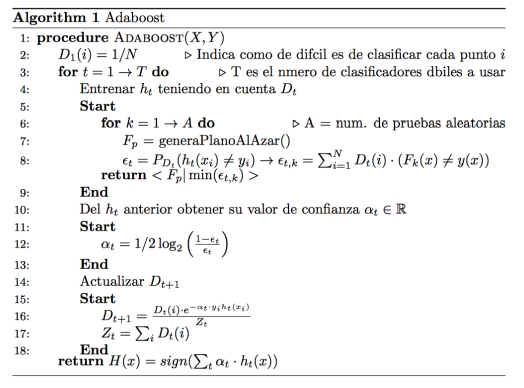

Nuestro algoritmo de adaboost devuelve un clasificador fuerte, el cual, estará formado a su vez de multitud de clasificadores débiles. Estos clasificadores débiles a nivel individual serán mejores o peores, pero al estar un conjunto de  estos, su precisión aumenta considerablemente. 

Un clasificador débil lo que realiza es, basandose en un pixel y un umbral, determina si cierta imagen pertenece o no a una cierta clase. 

El objetivo de esta práctica es construir y obtener un clasificador robusto que sea capaz de, dada una imagen, determinar que número es el que ha aparecido en la imagen. Buscaremos que dicho clasificador, tenga el mejor porcentaje de acierto posible y teniendo en cuenta los tiempos de entrenamiento y evaluación, ya que estos influirán considerablemente en la precisión del algoritmo.

Realizaremos estudios sobre que valores debemos asociar a T y a A para que la precisión comience a ser aceptable. 
Además, posteriormente realizaremos estudios sobre el tamaño óptimo que debería tener el conjunto de datos de entrenamiento, y cual sería un buen conjunto de datos para evaluar a nuestros clasificadores fuertes.

---
##**Implementación de AdaBoost**

El algortimo adaboost consiste en generar una serie de clasificadores débiles que, uniendo las decisiones de todos estos conformen un clasificador fuerte. 

En esta práctica vamos a generar primeramente un clasificador fuerte para el dígito 0, de forma que, dado un conjunto de imagenes, nuestro clasificador será capaz de distinguir si es o no un 0 lo que se le adjunta como imagen. 

Adaboost es un algoritmo de aprendizaje supervisado, de forma que tenemos un conjunto de entramiento (x_train) y sus respectivas etiquetas (y_train) que se refieren a la clase a la que pertenecen (es decir, el dígito escrito en la imagen). 

###**Funciones auxiliares**

Para el algoritmo adaboost hemos creado una serie de funciones auxiliares las cuales nos ayudarán a la legibilidad y comprensión del algoritmo en su totalidad.

#### *adaptar_conjuntos*
La función *adaptar_conjuntos* recibe como primer parámetro un conjunto de imágenes, como segundo el conjunto de etiquetas y como úlimo parámetro recibe la clase sobre la que estamos trabajando, es decir, sobre la cual vamos a construir el clasificador. En esta primera fase, vamos a crear el clasificador fuerte del 0, por lo que dicho parámetro será 0. 

Dicha función adaptará las imágenes del vector de imagen recibido (X) y las convertirá de su forma matricial a una estructura de vector unidimensional, de forma que podremos acceder a ella más cómodamente, accediendo por índice. 

Posteriormente, adaptará el conjunto recibido (Y), de forma que creará un vector con la misma longitud que este y, en las posiciones que se encuentre el valor objetivo (tag) insertará un 1 en dicha posición, indicando que en dicha posición, la imagen X correspondiente pertenece a la clase, de lo contrario, en dicha posición establecerá el valor -1.

In [ ]:
def adaptar_conjuntos(X, Y,tag):
  imgs = np.reshape(X, (len(X), 28*28))
  tags = []
  for i in range(len(Y)):
    if int(Y[i]) == int(tag):
      tags.append(1)
    else:
      tags.append(-1)
  return (imgs, tags)

mnist_X, mnist_Y = adaptar_conjuntos(x_train, y_train,0)
print("Shape de mnist_X: ", mnist_X.shape)
print("Shape de mnist_Y: ", len(mnist_Y))

Shape de mnist_X:  (60000, 784)
Shape de mnist_Y:  60000


####*generar_clasificador_debil*
La función generar_clasificador_debil lo que realiza es, dada la dimensión de los datos, establece el pixel en el que dicho clasificador se fijará, también establecerá el umbral límite y también la dirección, todo esto de forma pseudo-aleatoria.

In [ ]:
def generar_clasificador_debil(dimension_datos):
  # Devolvemos el clasificador débil generado
  pixel = np.random.randint(0,dimension_datos-1)
  umbral = np.random.randint(0,255)
  dir = random.choice([1,-1])

  return (pixel,umbral,dir) # (pixel, umbral, direccion)

####*aplicar_clasificador_debil*
Dado un clasificador y una imagen, aplica dicho clasificador a la imagen. Esto se realiza, accediendo al pixel establecido por el clasificador, y se fijará en este, obtendrá su valor, que estará contenido entre [0,255] y, en función también del umbral, el clasificador intentará determinar si se corresponde o no con el valor objetivo.

In [ ]:
def aplicar_clasificador_debil(clasificador, imagen):
  if clasificador[2] == 1:
    if clasificador[1] >= imagen[clasificador[0]]:
      return 1
    else:
      return -1
  else:
    if clasificador[1] <= imagen[clasificador[0]]:
      return 1
    else:
      return -1

####*obtener_error*
Dado un clasificador, el vector de imágenes, el vector de etiquetas y el vector de pesos sobre cada imagen, calcula el error del clasificador sobre dicho conjunto.

El clasificador se aplicará sobre todo el conjunto X, en caso de que no coincida el valor que estima el clasificador con el valor real de la etiqueta (almacenado en la componente respectiva del vector Y) se acumulará el peso de dicha imagen (almacenado en la componente respectiva del vector D), de forma que el error vendrá determinado por la suma de los pesos de las imágenes mal clasificadas.

In [ ]:
def obtener_error(clasificador, X, Y, D):
  sum = 0.0

  for i in range(len(X)):
    
    if aplicar_clasificador_debil(clasificador,X[i]) != Y[i]:
      sum = sum + D[i]

  return sum

### **Adaboost**
Aquí hemos implementado el algoritmo de adaboost, el cual recibe el vector de imágenes, el vector de etiquetas, el número de clasificadores débiles a crear (T), el número de intentos por clasificador (A) y la clase para la cual lo estamos entrenando (valores del 0-9, en este caso).
Esta función devuelve la lista de los clasificadores débiles y las ponderaciones (confianza) de cada clasificador.

In [ ]:
def adaboost(X, Y, T, A, clase):
  
  clasificadores_debiles = []
  alphas = []

  
  imagenes_X, etiquetas_Y = adaptar_conjuntos(X,Y,clase)

  # Distribuimos equitativamente
  D = np.full(len(Y), 1/len(etiquetas_Y)) 

  Z = 1 # np.sum(D)
  
  for i in range(0,T): # Numero de clasificadores débiles a usar

    fpMin = None
    min_err = 999

    for j in range(0,A): # Pruebas para generar clasificadores

      fp = generar_clasificador_debil(28*28) 
      err = obtener_error(fp,imagenes_X,etiquetas_Y,D)

      if fpMin is None:
        fpMin = fp
        min_err = err
      else:
        if min_err > err:
          fpMin = fp
          min_err = err

    if min_err <= 0.5:
      clasificadores_debiles.append(fpMin)
      alpha = 0.5 * math.log((1-min_err)/min_err,2) 
      alphas.append(alpha)
      Z = 0
    
      for k in range(len(imagenes_X)):
        D[k] = D[k] * e**(-1 * alpha * etiquetas_Y[k] * aplicar_clasificador_debil(fpMin, imagenes_X[k])) 
        Z = Z + D[k]  
      
      D = list(map(lambda n: n/Z,D))
    
  return (clasificadores_debiles, alphas)

Ahora vamos a comenzar con el entrenamiento, para esto, llamamos a la función adaboost con los conjuntos X e Y de entrenamiento asignados:



In [ ]:
cf = adaboost(x_train, y_train, 10, 10,0)

print("Lista de clasificadores({}): {}".format(len(cf[0]),cf[0]))
print("Lista de alphas({}): {}".format(len(cf[1]),cf[1]))

Lista de clasificadores(10): [(699, 160, -1), (754, 175, 1), (482, 141, -1), (215, 34, -1), (713, 168, 1), (656, 4, -1), (386, 87, -1), (241, 55, -1), (513, 172, -1), (467, 16, -1)]
Lista de alphas(10): [1.5953075634974756, 0.7062347470521673, 0.8858767740410085, 0.4683600291970704, 0.20522511353988387, 0.47879949833473895, 0.7340401802752625, 0.3553135855164457, 0.4793692230127615, 0.4033986318310317]


## Evaluación del algoritmo: Precisión.


Para analizar el algoritmo, vamos a calcular el porcentaje de aciertos con un conjunto de evaluación, el cual es un conjunto de imágenes que no hemos introducido anteriormente, por lo que nuestro clasificador fuerte tendrá que decidir si es o no un 0. Este cojunto es (x_test ,y_test) el cual hemos creado al comienzo de este documento.

In [ ]:
def evaluate(x,y,cf,digit):
  x_test_adapted, y_test_adapted = adaptar_conjuntos(x,y,digit)
  correct = 0
  
  for i in range(len(y_test_adapted)):
    # Aplicamos todos los clasificadores a la imagen x_test_adapted[i]
    result_classifier = list(map(lambda clasifier: aplicar_clasificador_debil(clasifier, x_test_adapted[i]), cf[0])) 

    # Hacemos el sumatorio del resultado de cada resultado por su alfa
    sum = list(map(lambda result,alf: result*alf ,result_classifier,cf[1]))

    # Sumamos todos los alfas*resultados
    sum = np.sum(sum)

    #      No es el valor a predecir              Sí es el valor a predecir
    if (sum < 0 and y_test_adapted[i] == -1) or (sum >= 0 and y_test_adapted[i] > 0):
      correct = correct + 1
    
  accuracy = 100*(correct/len(y_test_adapted))

  return accuracy

print("El modelo entrenado tiene una precisón del {}%.".format(evaluate(x_test,y_test,cf,0)))

El modelo entrenado tiene una precisón del 92.65%.


### Estudio de T con respecto a la precisión.###
Ahora vamos a evaluar la precisión del algoritmo con respecto a los valores que le demos a T, para ello, vamos a ejecutar una serie de pruebas con los valores 4, 8, 12, 16, 20, 40, 50, 70, 80, 90 y 100. El valor de A será constante y será 10.

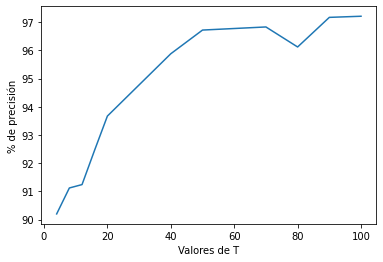

Precisión de adaboost con A=10 y T=4: 90.2%.
Precisión de adaboost con A=10 y T=8: 91.12%.
Precisión de adaboost con A=10 y T=12: 91.24%.
Precisión de adaboost con A=10 y T=16: 92.47%.
Precisión de adaboost con A=10 y T=20: 93.67%.
Precisión de adaboost con A=10 y T=40: 95.88%.
Precisión de adaboost con A=10 y T=50: 96.72%.
Precisión de adaboost con A=10 y T=70: 96.83%.
Precisión de adaboost con A=10 y T=80: 96.12%.
Precisión de adaboost con A=10 y T=90: 97.17%.
Precisión de adaboost con A=10 y T=100: 97.21%.


In [ ]:
T = [4,8,12,16,20,40,50,70,80,90,100]
A = 10
accuracy = []

(x_train, y_train), (x_test, y_test) = mnist.load_data()

for t in T:
  cf = adaboost(x_train,y_train,t, A, 0)
  percentage = evaluate(x_test,y_test,cf,0)
  accuracy.append(percentage)

plt.plot(T,accuracy)

plt.xlabel('Valores de T')
plt.ylabel('% de precisión')

plt.show()

for i in range(len(T)):
  print("Precisión de adaboost con A={} y T={}: {}%.".format(A,T[i],accuracy[i]))

Como podemos observar, cuantos más clasificadores débiles establezcamos, la precisión de nuestro clasificador va aumentando, aunque con T = 20 ya es considerablemente buena, a partir de 40 ya obtenemos más del 95% de precisión, lo que es un porcentaje de acierto considerablemente bueno. 

También es cierto, que a mayor T, mayor tiempo consumirá el entrenamiento, pero esto será evaluado posteriormente.

### Estudio de A con respecto a la precisión.
Ahora vamos a evaluar la precisión del algoritmo con respecto a los valores que le demos a A, para ello, vamos a ejecutar una serie de pruebas con los valores 4, 8, 12, 16, 20, 30, 40, 50, 70, 80, 90 y 100. El valor de T será constante y será 15.

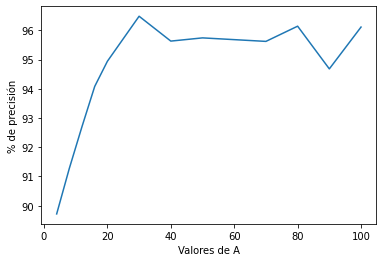

Precisión de adaboost con A=4 y T=15: 89.72%.
Precisión de adaboost con A=8 y T=15: 91.28%.
Precisión de adaboost con A=12 y T=15: 92.71000000000001%.
Precisión de adaboost con A=16 y T=15: 94.08%.
Precisión de adaboost con A=20 y T=15: 94.94%.
Precisión de adaboost con A=30 y T=15: 96.48%.
Precisión de adaboost con A=40 y T=15: 95.63000000000001%.
Precisión de adaboost con A=50 y T=15: 95.74000000000001%.
Precisión de adaboost con A=70 y T=15: 95.62%.
Precisión de adaboost con A=80 y T=15: 96.14%.
Precisión de adaboost con A=90 y T=15: 94.67999999999999%.
Precisión de adaboost con A=100 y T=15: 96.11%.


In [ ]:
A = [4,8,12,16,20,30,40,50,70,80,90,100]
T = 15
accuracy = []

(x_train, y_train), (x_test, y_test) = mnist.load_data()

for a in A:
  cf = adaboost(x_train,y_train,T, a, 0)
  percentage = evaluate(x_test,y_test,cf,0)
  accuracy.append(percentage)

plt.plot(A,accuracy)

plt.xlabel('Valores de A')
plt.ylabel('% de precisión')

plt.show()

for i in range(len(A)):
  print("Precisión de adaboost con A={} y T={}: {}%.".format(A[i],T,accuracy[i]))

Como podemos observar, el valor de A influye también considerablemente en la mejora de precisión del algoritmo. Un valor considerablemente bueno sería, por ejemplo A = 50, con el cual solemos obtener siempre por encima del 95% de precisión. 

### Prueba con los mejores valores obtenidos de T y A de forma independiente.
Ahora vamos a realizar una prueba, es decir, a evaluar nuestro modelo con los mejores valores obtenidos en los estudios realizados anteriormente, por lo que cogeremos los valores de:


*   A = 50
*   T = 20

Procedemos a la evaluación:

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

cf16 = adaboost(x_train,y_train,16,16,0)
cf50 = adaboost(x_train,y_train,50,50,0)
cfMezcla = adaboost(x_train,y_train,20,50,0)

print("Precisión de adaboost con A=20 y T=20: {}%.".format(evaluate(x_test,y_test,cf16,0)))
print("Precisión de adaboost con A=50 y T=20: {}%.".format(evaluate(x_test,y_test,cfMezcla,0)))
print("Precisión de adaboost con A=50 y T=50: {}%.".format(evaluate(x_test,y_test,cf50,0)))

Precisión de adaboost con A=20 y T=20: 95.93%.
Precisión de adaboost con A=50 y T=20: 95.88%.
Precisión de adaboost con A=50 y T=50: 96.72%.


Como podemos observar, con A = 50 y T = 50 obtenemos una precisión del 96,72% lo que ya se acerca considerablemente al 100%, el problema de esto, es que tiene un coste de entrenamiento bastante elevado comparado con T=20 y A=50.

Hay que tener en cuenta que, generalmente, cuantos más clasificadores débiles y más intentos de cada clasificador débil hagamos, más mejorará el porcentaje de acierto, esto se debe a que cada clasificador débil será mejor individualmente (existe más probabilidad de encontrar uno que sea bueno) y además encontramos también que existen bastantes clasificadores. Un valor que considero bastante bueno es con los valores de A oscilando entre [16, 50] y los valores de T también.

También podemos observar que el porcentaje de acierto con A = 16 y T = 16 es del ~95%.



### Estudio conjunto de A y T con respecto a la precisión. ###

Ahora vamos a evaliar la precisión del algoritmo cuando varía A y cuando varía T, para esto, tendremos que representarlo en un espacio, ya que necesitamos 3 dimensiones. Para este estudio, hemos reducido las muestras de entrenamiento y evaluación, ya que sino, la complejidad de entrenamiento debido al hecho de que hay que probar todas las combinaciones sería muy alta. Se ha decidido que para el entrenamiento se utilicen 3.000 muestras y para la evaluación de dicho clasificador un total de 250.

Valores a comprobar de T:  [  8  12  16  20  25  50  75 100 150 200 300]
Valores a comprobar de A:  [  8  12  16  20  25  50  75 100 150 200 300]
Matriz de porcentajes de acierto
-------------------------------
 [[ 93.6  95.2  94.8  95.2  97.6  96.8  97.6  98.8  99.2  99.2  98.4]
 [ 91.6  95.2  94.   98.   94.4  98.8  97.6  98.4  98.8  98.8  99.6]
 [ 94.   97.2  97.2  95.6  96.8  97.2  98.4  99.2  99.2  98.   99.6]
 [ 95.2  96.4  94.8  96.   98.   97.6  97.6  98.4  99.2  99.2  98.8]
 [ 93.2  97.6  95.6  96.4  96.4  98.4  98.4  98.4  98.4  99.2  99.6]
 [ 97.2  96.4  96.4  95.2  98.4  99.2  99.2  99.2  99.2  99.6  99.2]
 [ 94.8  97.6  98.4  99.2  96.8  98.8  99.2  99.2  98.8 100.   99.6]
 [ 96.   97.6  97.6  97.6  98.   98.8  98.   99.6  99.2  99.6  99.2]
 [ 95.2  94.8  97.2  98.4  98.   98.8  98.4  99.2  99.6  98.8  99.6]
 [ 96.   98.   97.6  97.6  98.4  98.8  98.8  98.8  99.6 100.   99.2]
 [ 95.6  98.4  97.6  98.8  96.8  98.8  99.2  99.2 100.  100.   99.6]]


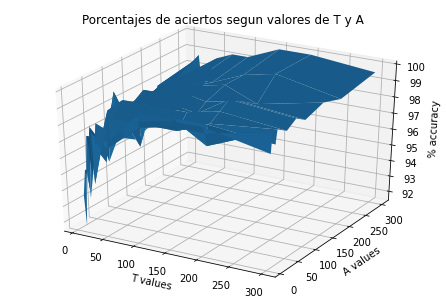

In [ ]:
t = [8,12,16,20,25,50,75,100,150,200,300]
a = [8,12,16,20,25,50,75,100,150,200,300]

t = np.asarray(t)
a = np.asarray(a)

T, A = np.meshgrid(t, a)

print("Valores a comprobar de T: ",t)
print("Valores a comprobar de A: ",a)

Z = np.asarray(list(map(lambda tFila, aFila: np.asarray(list(map(lambda tValue, aValue: evaluate(x_test[:250],y_test[:250],adaboost(x_train[:3000],y_train[:3000],tValue,aValue,0),0),tFila, aFila)))  ,T,A)))


print("Matriz de porcentajes de acierto\n-------------------------------\n",Z) 


fig = plt.figure()
 
axes3d = Axes3D(fig)

axes3d.set_xlabel('T values')
axes3d.set_ylabel('A values')
axes3d.set_zlabel('% accuracy')
axes3d.set_title("Porcentajes de aciertos segun valores de T y A")

axes3d.plot_surface(T,A,Z)

Como podemos observar, lo que más produce mejora en el sistema, es decir, aumenta la precisión del mismo es el aumento de clasificadores, aun así, teniendo un número considerablemente pequeño de A también produce que la precisión baje notablemente. 

La solución óptima es poner un número considerable para ámbos, A entorno a [40,80] y T entorno a los [50,100]. Cualquier combinación de valores con A y T pertenecientes a dichos intervalos obtendrá valores de precisión superiores al 98% de acierto, lo que consideramos un valor considerablemente bueno.


## Evaluación del algoritmo: Distintos tamaños de conjunto.##
Ahora vamos a realizar una evaluación del porcentaje de acierto del algoritmo con valores fijos de T y A, únicamente variarán la cantidad de imágenes que utilizaremos para entrenar el algoritmo y para evaluarlo. Esto se debe realizar ya que necesitamos un conjunto de datos para entrenar el algoritmo y ajustar sus parámetros. Posteriormente necesitaremos otro conjunto compuesto de datos que este clasificador no haya visto anteriormente, de forma que seamos capaces de evaluar su porcentaje de acierto con muestras reales (no las ha visto antes). En caso de no tener muestras suficientes, se pueden utilizar algún tipo de técnica como puede ser el Cross-validation.

Para distribuir los tamaños de entrenamiento y test, cogeremos el conjunto de las 60.000 imágenes del MNIST que lo almaceno en la variable *x_train* y lo segmentaré en función del porcentaje a utilizar. En el caso de querer probar con el 10% del conjunto, se cogerá el 10% de las 60.000 imágenes y se generará una instancia del clasificador del 0 siendo entrenado con dichas imágenes. Posteriormente, se evaluará dicho clasificador con el 90% de las imágenes restantes (90% de las 60.000 imágenes, en las cuales no se incluyen las utilizadas para el entrenamiento).

Los valores fijos de T y A que vamos a utilizar para este estudio son T=25 y A=25.

Dividiremos los conjuntos en 8 distribuciones distintas y, observamos los resultados a continuación:

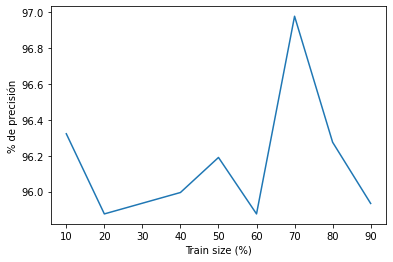

Precisión de adaboost con: train_size=10.0% y evaluate_size=90.0%: 96.32222222222222%.
Precisión de adaboost con: train_size=20.0% y evaluate_size=80.0%: 95.875%.
Precisión de adaboost con: train_size=40.0% y evaluate_size=60.0%: 95.99444444444445%.
Precisión de adaboost con: train_size=50.0% y evaluate_size=50.0%: 96.19%.
Precisión de adaboost con: train_size=60.0% y evaluate_size=40.0%: 95.875%.
Precisión de adaboost con: train_size=70.0% y evaluate_size=30.0%: 96.97777777777777%.
Precisión de adaboost con: train_size=80.0% y evaluate_size=20.0%: 96.275%.
Precisión de adaboost con: train_size=90.0% y evaluate_size=10.0%: 95.93333333333334%.


In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

T, A = 25, 25

# Porcentajes del conjunto que usarán, el porcentaje de evaluación que se usará
# será 1-entreno[indice]
entreno = [0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] 

# Tamaño de la muestra total
tam = len(y_train)

# Ejecutamos division.
entreno = list(map(lambda x: int(x*tam), entreno))

accuracy = []

for i in range(len(entreno)):
  
  cf = adaboost(x_train[:entreno[i]],y_train[:entreno[i]],T, A, 0)
  percentage = evaluate(x_train[entreno[i]:],y_train[entreno[i]:],cf,0)

  accuracy.append(percentage)

entreno = list(map(lambda x: x*100/tam,entreno))
plt.plot(entreno,accuracy)

plt.xlabel('Train size (%)')
plt.ylabel('% de precisión')

plt.show()

for i in range(len(entreno)):
  print("Precisión de adaboost con: train_size={}% y evaluate_size={}%: {}%.".format(entreno[i],100-entreno[i],accuracy[i]))

Como podemos observar, la distribución óptima que hemos obtenido es repartiendo el 70% para entrenamiento y el otro 30% para tests. Con esta distribución obtenemos, dependiendo de la ejecución, pero siempre alrededor de un 96.5% de precisión (aproximadamente, ya que, los clasificadores son aleatorios siempre). 

Por lo que consideraremos como óptimo atribuir el 70% del conjunto al entrenamiento y el 30% restante al apartado de la evaluación del clasificador.

## Evaluación del algoritmo: Tiempo. ##
El tiempo que tarda el algoritmo en entrenarse en muchas ocasiones puede llegar a ser relevante, ya que, como es nuestro caso, se hace a modo educativo y no interesa que un algoritmo esté entrenando largos periodos de tiempo.

En los siguientes apartados veremos como varía el tiempo de entrenamiento con respecto a los parámetros de T y A.



### Estudio de T con respecto al tiempo.

Primero vamos a ver como varía el tiempo de entrenamiento variando el parámetro T. El parámetro A será fijo y será 20.

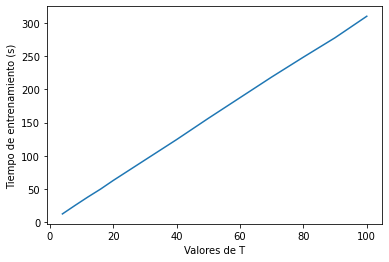

Tiempo de entrenamiento de adaboost con A=20 y T=4: 12.730407476425171s.
Tiempo de entrenamiento de adaboost con A=20 y T=8: 25.558658361434937s.
Tiempo de entrenamiento de adaboost con A=20 y T=12: 38.056429386138916s.
Tiempo de entrenamiento de adaboost con A=20 y T=16: 49.95063805580139s.
Tiempo de entrenamiento de adaboost con A=20 y T=20: 62.93511486053467s.
Tiempo de entrenamiento de adaboost con A=20 y T=30: 93.71428728103638s.
Tiempo de entrenamiento de adaboost con A=20 y T=40: 124.43873739242554s.
Tiempo de entrenamiento de adaboost con A=20 y T=50: 156.3625292778015s.
Tiempo de entrenamiento de adaboost con A=20 y T=70: 218.53291630744934s.
Tiempo de entrenamiento de adaboost con A=20 y T=80: 248.42238926887512s.
Tiempo de entrenamiento de adaboost con A=20 y T=90: 277.64053869247437s.
Tiempo de entrenamiento de adaboost con A=20 y T=100: 309.92547941207886s.


In [ ]:
T = [4,8,12,16,20,30,40,50,70,80,90,100]
A = 20
cronom = []

for t in T:
  tIni = time.time()
  cf = adaboost(x_train, y_train ,t , A, 0)
  tFin = time.time()
  cronom.append(tFin-tIni)

plt.plot(T,cronom)

plt.xlabel('Valores de T')
plt.ylabel('Tiempo de entrenamiento (s)')

plt.show()

for i in range(len(T)):
  print("Tiempo de entrenamiento de adaboost con A={} y T={}: {}s.".format(A,T[i],cronom[i]))

Como podemos observar, el tiempo que tarda en ejecutarse el entrenamiento de nuestro clasificador se correlaciona de forma lineal con los valores de T. Conforme aumentemos T, aumentará el tiempo de entrenamiento. Un valor considerablemente bueno de T sería 50. La pendiente de la recta sería aproximadamente:

*y = 3x*

Siendo la variable x el valor de T que asignemos y la Y el tiempo que tarda en ejecutarse, por lo que el tiempo invertido incrementa considerablemente pero no son prohibitivamente grandes los tiempos de entrenamiento, al menos en las dimensiones en las que estamos probando.

###Estudio de A con respecto al tiempo. ###
A continuación, vamos a realizar el mismo estudio que antes pero ahora intercambiando la variable a analizar, por lo que ahora, analizaremos lo que varía el tiempo de entrenamiento con respecto a la variable A. La variable T se mantendrá constante a T=20.

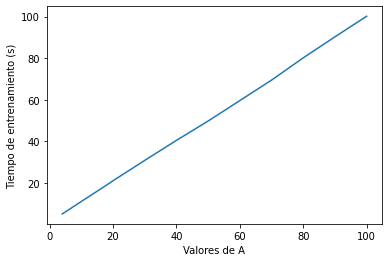

Tiempo de entrenamiento de adaboost con A=4 y T=20: 5.178854465484619s.
Tiempo de entrenamiento de adaboost con A=8 y T=20: 9.159940958023071s.
Tiempo de entrenamiento de adaboost con A=12 y T=20: 13.139503479003906s.
Tiempo de entrenamiento de adaboost con A=16 y T=20: 17.06332230567932s.
Tiempo de entrenamiento de adaboost con A=20 y T=20: 21.11000967025757s.
Tiempo de entrenamiento de adaboost con A=30 y T=20: 30.88240122795105s.
Tiempo de entrenamiento de adaboost con A=40 y T=20: 40.49891805648804s.
Tiempo de entrenamiento de adaboost con A=50 y T=20: 49.796443939208984s.
Tiempo de entrenamiento de adaboost con A=70 y T=20: 69.45215320587158s.
Tiempo de entrenamiento de adaboost con A=80 y T=20: 80.15033793449402s.
Tiempo de entrenamiento de adaboost con A=90 y T=20: 90.24298024177551s.
Tiempo de entrenamiento de adaboost con A=100 y T=20: 100.13232731819153s.


In [ ]:
A = [4,8,12,16,20,30,40,50,70,80,90,100]
T = 20
cronom = []

for a in A:
  tIni = time.time()
  cf = adaboost(x_train[:20000], y_train[:20000] ,T , a, 0)
  tFin = time.time()
  cronom.append(tFin-tIni)

plt.plot(A,cronom)

plt.xlabel('Valores de A')
plt.ylabel('Tiempo de entrenamiento (s)')

plt.show()

for i in range(len(A)):
  print("Tiempo de entrenamiento de adaboost con A={} y T={}: {}s.".format(A[i],T,cronom[i]))

Como podemos observar, el tiempo que tarda en ejecutarse el entrenamiento de nuestro clasificador se correlaciona de forma lineal con los valores de A. Conforme aumentemos A, aumentará el tiempo de entrenamiento. Un valor considerablemente bueno de A sería 80, ya que aumentamos el número de intentos por clasificador y no penaliza de forma considerable al algoritmo (a nivel temporal). La pendiente de la recta sería aproximadamente:

*y = x*

Por lo que es un relación considerablemente buena y podemos aumentar sin temor el valor de A, al menos para valores de T no muy grandes, ya que por cada T, se ejecutan A intentos, por lo que crece de forma exponencial. 



##Evaluación del algoritmo: Overfitting.##


Ahora vamos a realizar un estudio para observar sobre que valores se produce overfitting (sobreentrenamiento).

El sobreentrenamiento es entrenar tanto un modelo con un conjunto de entrenamiento que este solo resuelva los valores que componen dicho conjunto de entrenamiento, debido a que se ha aprendido los ejemplos concretos y no ha aprendido de sus características. Por ello, debemos encontrar el punto donde comienza a haber sobreentrenamiento en nuestro adaboost, para esto, vamos a realizar un análisis para valores de T considerablemente grandes:

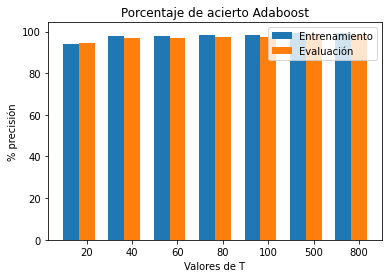

In [ ]:
acc_entreno = []
acc_eval    = []

T = [20,40,60,80,100,500,800]
A = 20

for t in T:
  acc_entreno.append(evaluate(x_train[:5000],y_train[:5000],adaboost(x_train[:20000],y_train[:20000],t, A,0),0))
  acc_eval.append(evaluate(x_test[:5000],y_test[:5000],adaboost(x_train[:20000],y_train[:20000],t, A,0)),0)
 
nGrupos = len(acc_entreno)
indice_barras = np.arange(nGrupos)
ancho_barras =0.35
 
plt.bar(indice_barras, acc_entreno, width=ancho_barras, label='Entrenamiento')
plt.bar(indice_barras + ancho_barras, acc_eval, width=ancho_barras, label='Evaluación')

plt.legend(loc='best')

## Se colocan los indicadores en el eje x
plt.xticks(indice_barras + ancho_barras, T)
 
plt.ylabel('% precisión')
plt.xlabel('Valores de T')
plt.title('Porcentaje de acierto Adaboost')
 
plt.show()

Como podemos observar, respecto a los valores de T, no se produce sobreentrenamiento, es decir, los valores de precisión con ambos conjuntos son muy similares, por lo que, hasta el momento no hemos observado casos de sobreentrenamiento. 

A pesar de esto, podríamos haber obtenido sobreentrenamiento y nuestro clasificador no hubiera sido tan bueno como debería, por lo que, vamos a adaptar la función adaboost para que detecte el sobreentrenamiento y, en caso de detectarlo, pare el entrenamiento del clasificador. 

## Adaboost preparado para sobreentrenamiento##

El algoritmo de adaboost preparado para sobreentrenamiento es el siguiente:

In [ ]:
def adaboost(X, Y, T, A, clase):
  
  clasificadores_debiles = []
  alphas = []

  imagenes_X, etiquetas_Y = adaptar_conjuntos(X,Y,clase)
  
  
  accuracy = []

  # Distribuimos equitativamente
  D = np.full(len(Y), 1/len(etiquetas_Y)) 

  Z = 1 # np.sum(D)
  
  for i in range(0,T): # Numero de clasificadores débiles a usar

    fpMin = None
    min_err = 999

    for j in range(0,A): # Pruebas para generar clasificadores

      fp = generar_clasificador_debil(28*28) 
      err = obtener_error(fp,imagenes_X,etiquetas_Y,D)

      if fpMin is None:
        fpMin = fp
        min_err = err
      else:
        if min_err > err:
          fpMin = fp
          min_err = err

    if min_err <= 0.5:
      clasificadores_debiles.append(fpMin)
      alpha = 0.5 * math.log((1-min_err)/min_err,2) 
      alphas.append(alpha)
      Z = 0
    
      for k in range(len(X)):
        D[k] = D[k] * e**(-1 * alpha * etiquetas_Y[k] * aplicar_clasificador_debil(fpMin, imagenes_X[k])) 
        Z = Z + D[k]  
      
      D = list(map(lambda n: n/Z,D))

    # Codigo añadido #

    if i > 5:
      last = evaluate(x_test,y_test, (clasificadores_debiles,alphas),clase)
      accuracy.append(last)

      meanAccuracy = sum(accuracy[-6:-1])/5

      diff = last-meanAccuracy
      if ( diff < 0 and  abs(diff) > 3):
        break
    else:
      accuracy.append(evaluate(x_test,y_test, (clasificadores_debiles,alphas),clase))
    ########


    
  return (clasificadores_debiles, alphas)

He considerado, bajo mi propio criterio, que a partir de 5 clasificadores débiles, se evaluará siempre si la precisión nueva obtenida es mayor que la media de las 5 últimas iteraciones. En caso de que la nueva precisión sea inferior que dicha media y la diferencia de la última precisión obtenida sea mayor de un 3% respecto a dicha media, consideraré que se trata de sobreentrenamiento y pararemos el entrenamiento del algoritmo.

## Adaboost completo ##

###Concepto###
Una vez realizado el estudio completo de un clasificador (hecho con el clasificador del 0), vamos a construir 10 clasificadores, cada uno correspondiente con un dígito manuscrito (0-9). 

De forma que el objetivo es obtener una estructura en la que tengamos almacenados los clasificadores fuertes correspondientes a cada dígito. En mi caso, dicha estuctura de datos será una lista. Esto lo obtendremos para que, a partir de ahora, nos pasarán una imagen (o conjunto de estas) y tendremos que determinar de qué dígito manuscrito se trata. 

Para esto, lo que primero necesitamos es una función que nos construya dicho clasificador, como, en nuestro caso es, *generarClasificadorCompleto()*.

###Implementación

####*generarClasificadorCompleto*####
Este método nos generará 10 clasificadores, cada uno especializado en una clase (número). Todos los clasificadores débiles que vamos a generar se construirán con los mismos valores de T y de A, a su vez, también serán entrenados con el mismo conjunto de entrenamiento. Todos esos valores serán recibidos como parámetro.

In [ ]:
"""
  Recibe la T, A y la cantidad de imagenes de entrenamiento.
  Devuelve el vector de clasificadores fuertes
"""
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Lo que devuelve es una tupla con (clasificador, % accuracy)
def generarClasificadorCompleto(tValue,aValue,imagenes_entreno):
  
  hCompleto = []
  
  if imagenes_entreno > 60000:
    imagenes_entreno = 60000

  for i in range(0,10):
    ada = adaboost(x_train[0:imagenes_entreno], y_train[0:imagenes_entreno],tValue,aValue,i)
    hCompleto.append((ada, evaluate(x_test[:5000], y_test[:5000],ada,i)))

  return hCompleto

Además, dicha función devolverá una lista con el clasificador de cada uno de los dígitos (el clasificador de cada dígito se corresponderá con la posición correspondiente del vector). 
Además, para reducir la complejidad, calculo a la vez que genero los clasificadores fuerte, el porcentaje de acierto de cada uno de ellos. 
Por lo que la lista que devuelve la función *generarClasificadorCompleto*, devuelve una lista de tuplas, donde en cada posición de la lista se encontrará en primera posición el clasificador y en la segunda el porcentaje de acierto de este. Dicho porcentaje será utilizado posteriormente en la heurística que he utilizado para determinar que dígito se encuentra representado en dicha imagen. 

In [ ]:
H = generarClasificadorCompleto(30,30,15000)

for i in range(0,10):
  print("Clasificadores fuerte del dígito '{}' el cual posee un {}% de acierto.".format(i,round(H[i][1],2)))

Clasificadores fuerte del dígito '0' el cual posee un 95.96% de acierto.
Clasificadores fuerte del dígito '1' el cual posee un 95.68% de acierto.
Clasificadores fuerte del dígito '2' el cual posee un 93.48% de acierto.
Clasificadores fuerte del dígito '3' el cual posee un 92.2% de acierto.
Clasificadores fuerte del dígito '4' el cual posee un 92.96% de acierto.
Clasificadores fuerte del dígito '5' el cual posee un 92.04% de acierto.
Clasificadores fuerte del dígito '6' el cual posee un 95.22% de acierto.
Clasificadores fuerte del dígito '7' el cual posee un 94.38% de acierto.
Clasificadores fuerte del dígito '8' el cual posee un 91.52% de acierto.
Clasificadores fuerte del dígito '9' el cual posee un 92.24% de acierto.


####*obtenerEtiqueta*###


Recapitulando, tendremos una lista la cual es un clasificador fuerte compuesto, ya que es una estructura de datos compuesta de muchos clasificadores fuertes y sus respectivas precisiones. 

Ahora tendremos que decidir la heurística con la cual obtendremos la salida, esto se debe a que cada clasificador fuerte tiene una salida binaria:
*   -1: Cierta imagen no pertence a la clase de dicho clasificador.
*    1: Cierta imagen sí pertenece a la clase de dicho clasificador.

Para esto usaremos los porcentajes de acierto asociados correspondientes, es decir, en caso de que únicamente 1 clasificador devuelva que cierta imagen es de su clase devolveremos dicha clase, ya que todos los demás consideran que dicha imagen no se corresponde con su clase. 

En el supuesto caso en el que más de un clasificador fuerte (incluso, podrían llegar a ser todos), determinen que cierta imagen pertenece a su clase, nos fijaremos en los errores asociados a cada clasificador, para ello, evaluaremos los clasificadores con una muestra de 2500 pruebas. Dentro del conjunto de clasificadores que se atribuyen que cierta imagen corresponde a su clase, nos quedaremos con la clase cuyo clasificador obtenga mejor porcentaje de acierto, ya que, de forma coloquial, podemos decir que es "el que menos se equivoca" o "del que más nos podemos fiar".

Por otro lado, en caso de que ningún clasificador se atribuya dicha imagen como que pertenece a su respectiva clase, es decir, que la imagen no coincide con ninguno de los dígitos posibles. Ya que sabemos que en la Base de Datos solo se encuentran estos dígitos, sabemos que dicha imagen pertenecerá a alguna de las clases de los clasificadores fuertes, por lo que, sabemos que es imposible que se de la situación de que no pertenezca a ninguna de las clases. 

Para solucionar esta problemática, evaluaremos todos los clasificadores y nos quedaremos con aquella clase que corresponda con el clasificador que menor porcentaje de acierto obtenga. Esto es correcto ya que, los demás, al tener más porcentaje de acierto, están más seguros de que dicho elemento no pertenece a su clase, por lo que, podríamos decir que dicho clasificador es el candidato más probable a cometer un error, por lo que determinaremos que dicha imagen pertenece a la clase del clasificador con menor porcentaje de acierto.


In [ ]:
def obtenerEtiqueta(cfc, img):

  etiquetaResultado = -1
  img = np.reshape(img, 28*28)
  accuracyVector = []
  test = 2500

  decisionList = []
  
  for i in range(0,10):
    
    result_classifier = list(map(lambda clasifier: aplicar_clasificador_debil(clasifier, img), cfc[i][0][0])) 

    # Hacemos el sumatorio del resultado de cada resultado por su alfa
    sum = list(map(lambda result,alf: result*alf ,result_classifier,cfc[i][0][1]))

    # Sumamos todos los alfas*resultados
    sum = np.sum(sum)

    if sum < 0:
      # No pertenece a la clase
      decisionList.append(-1)
    else:
      # Pertenece a la clase
      decisionList.append(1)
  
  if len(list(filter(lambda x: x==1,decisionList))) == 1:
    # 1 solo resultado, debemos devolver la etiqueta que 
    # coincide con la posicion en el vector
    for i in range(0,10):
      if decisionList[i] == 1:
        etiquetaResultado = i
        break
  else:
    
    better = 0
    if len(list(filter(lambda x: x==1, decisionList))) == 0:
      # Nadie piensa que pertenece a su clase, cogemos el de máximo error, 
      # que es lo mismo que coger el de menor % de acierto.

      better = 999

      for i in range(0, 10):
        better = min(better, cfc[i][1])
        etiquetaResultado = i if cfc[i][1] == better else etiquetaResultado

    else:
      # Varios se atribuyen dicha imagen, cogemos el de menor error,
      # el cual se corresponde con el de mayor % de acierto
      
      better = -999

      for i in range(0,10):
        if decisionList[i] == 1:
          better = max(better, cfc[i][1])
          etiquetaResultado = i if cfc[i][1] == better else etiquetaResultado
  

  return etiquetaResultado

Un ejemplo de predicción con 10 imágenes para valores fijos de T y A sería el siguiente:

In [ ]:
H = generarClasificadorCompleto(30,30,10000)

for i in range(10):
  num = random.randint(0,len(y_test)-1)
  print("Etiqueta obtenida con el clasificador: '{}', etiqueta real: '{}'.".format(obtenerEtiqueta(H,x_test[num]),y_test[num]))

Etiqueta obtenida con el clasificador: '0', etiqueta real: '5'
Etiqueta obtenida con el clasificador: '5', etiqueta real: '3'
Etiqueta obtenida con el clasificador: '3', etiqueta real: '3'
Etiqueta obtenida con el clasificador: '1', etiqueta real: '1'
Etiqueta obtenida con el clasificador: '5', etiqueta real: '0'
Etiqueta obtenida con el clasificador: '1', etiqueta real: '1'
Etiqueta obtenida con el clasificador: '1', etiqueta real: '1'
Etiqueta obtenida con el clasificador: '7', etiqueta real: '7'
Etiqueta obtenida con el clasificador: '5', etiqueta real: '2'
Etiqueta obtenida con el clasificador: '5', etiqueta real: '9'


### Evaluación del clasificador compuesto completo
Una vez obtenido dicha lista, en la cual almacenaremos todos los clasificadores correspondientes a cada dígito, probaremos una cantidad *nPruebas* de imágenes para evaluar el clasificador completo, para esto, he creado la función *testClasificadorCompleto* la cual recibe dicho clasificador compuesto de los clasificadores fuertes y el número de pruebas que debe realizar. Esta función devolverá el porcentaje de acierto en las nPruebas

In [ ]:
def testClasificadorCompleto(cfc,nPruebas):
  
  hit = 0
  for i in range(0,nPruebas):
    nImg = random.randint(0,len(y_test)-1)

    eti_obtenida = obtenerEtiqueta(cfc, x_test[nImg])
    eti_real     = y_test[nImg]

    if eti_obtenida == eti_real:
      hit = hit + 1

  return 100*hit/nPruebas

Ahora vamos a realizar una serie de pruebas, con el clasificador compuesto para distintos valores de T. Dicho test es el siguiente:

% de acierto con adaboost completo con A=50 y T=10: 50.2%.
% de acierto con adaboost completo con A=50 y T=20: 64.84%.
% de acierto con adaboost completo con A=50 y T=30: 69.04%.
% de acierto con adaboost completo con A=50 y T=40: 69.88%.
% de acierto con adaboost completo con A=50 y T=50: 72.72%.
% de acierto con adaboost completo con A=50 y T=60: 74.52%.
% de acierto con adaboost completo con A=50 y T=70: 74.52%.
% de acierto con adaboost completo con A=50 y T=80: 75.8%.
% de acierto con adaboost completo con A=50 y T=90: 75.72%.
% de acierto con adaboost completo con A=50 y T=100: 76.68%.


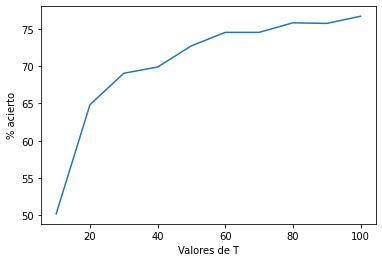

In [ ]:
T = [10, 20, 30, 40, 50, 60,70,80,90,100]
A = 50
percentage = []

(x_train, y_train), (x_test, y_test) = mnist.load_data()

for t in T:
  cc = generarClasificadorCompleto(t, A, 12500)
  p = testClasificadorCompleto(cc, 2500)
  percentage.append(p)
  print("% de acierto con adaboost completo con A={} y T={}: {}%.".format(A,t,p))


plt.plot(T,percentage)

plt.xlabel('Valores de T')
plt.ylabel('% acierto')

plt.show()

Como podemos observar, conforme aumentamos el número de T aumenta también la precisión de nuestro clasificador, pero a su vez, aumenta también considerablemente el tiempo de entrenamiento. He considerado apropiado poner como tamaño del conjunto de entranmiento 12500 y 2500 para evaluación, ya que así saldrían valores fiables y a nivel de tiempo es asequible. 

Analizando lo obtenido, un buen valor de T sería 50 y obtendríamos más de un 70% de aciertos para todo el conjunto de datos posibles en este conjunto. 

El clasificador compuesto funciona considerablemente bien, si dispusieramos de mejores recursos hardware o el tiempo no fuera relevante aumentaríamos el tamaño de entrenamiento y, probablemente también los valores de T y A, de forma que obtendríamos muy probablemente porcentajes de acierto cercanos al 90%. 

Otro parámetro a tener en cuenta es que lo ideal para el entrenamiento de los respectivos clasificadores fuertes sería haber equilibirado los conjuntos de entrenamiento. Estos, se equilibrarían estableciendo el 50% del conjunto que corresponda con imágenes que pertenecen a dicha clase (son imágenes del dígito para el cual se está entrenando) y el otro 50% corresponda con imágenes que no son de la clase objetivo.

##Conclusión
En este estudio hemos observado como con un algoritmo basado en clasificadores débiles y en boosting, concretamente el algoritmo adaboost, somos capaces de generar clasificadores fuertes dotados de precisión para distinguir si cierta imagen de un digito corresponde con el dígito objetivo de dicho clasificador o no con porcentajes considerablemente altos. 

Tambien hemos observado como los parámetros T y A influyen en la precisión y tiempo de entrenamiento del clasificador. Además, hemos observado que variar el tamaño del conjunto de entrenamiento hace que varíe considerablemente la precisión de nuestro clasificador.

Por último, hemos sido capaces de construir un clasificador compuesto el cual se compone de los clasificadores del 0-9, por lo que hemos conseguido clasificar imágenes en los distintos dígitos con porcentajes de acierto considerablemente buenos.